In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, ParameterGrid

plt.style.use("seaborn-v0_8")
random_state = 42

---
# Support Vector Machine [(SVC doc)](https://scikit-learn.org/stable/modules/svm.html#svc)

- A support vector machine constructs a hyper-plane (or set of hyper-planes) in a high or infinite dimensional space, which can be used for classification, regression or other tasks. <br>
- Intuitively, a good separation is achieved by the hyper-plane that has *the largest distance to the nearest training data points of any class* (so-called **functional margin**), since in general the larger the margin the lower the generalization error of the classifier.<br>
The figure below shows the decision function for a linearly separable problem, with three samples on the margin boundaries, called ***support vectors***:

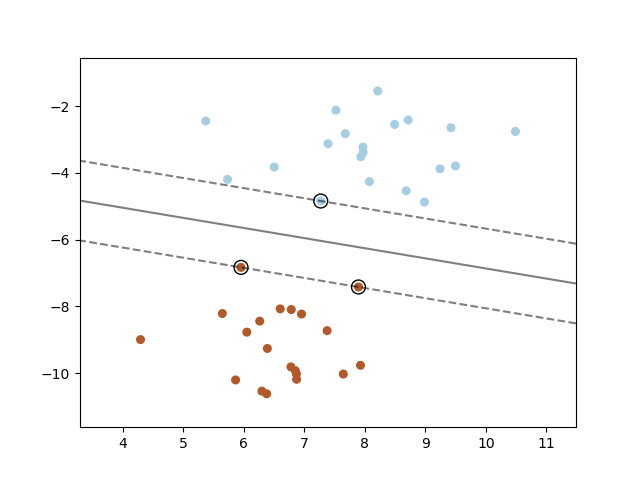
<br>
- In general, when the problem isn’t linearly separable, the support vectors are the samples within the margin boundaries.

- Practical details:
    - It is highly recommended to *scale the data* (both train and test) (min-max alike, or std-scaler alike)
    - If the data is *unbalanced* (e.g. many positive and few negative), set class_weight='balanced' and/or try different penalty parameters C.
    - SVM does not suffer from the curse of dimensionality: does not use any notion of distance
    - SVMs do not directly provide probability estimates. Nevertheless, SVM can produce a confidence score related to the distance of an example from the separation hyperplane.

In [2]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 3]]
encoder = LabelEncoder()
df_Y = encoder.fit_transform(df["Class"])

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_Y, test_size=0.33, random_state=random_state
)

ParamGrid length: 432


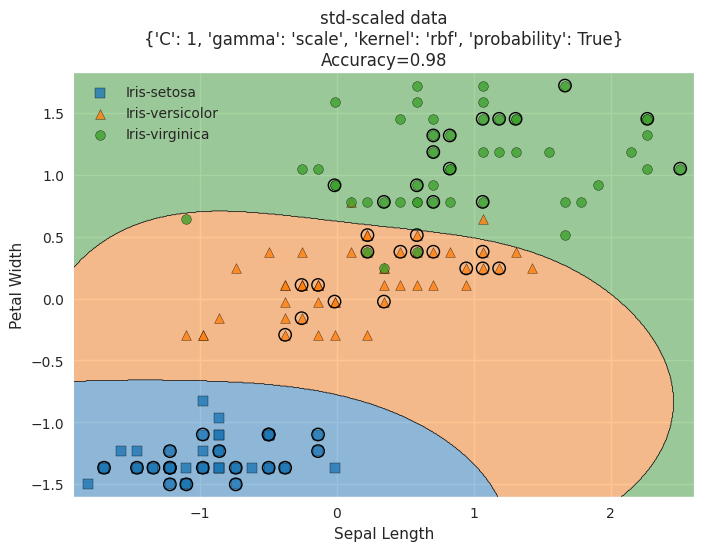

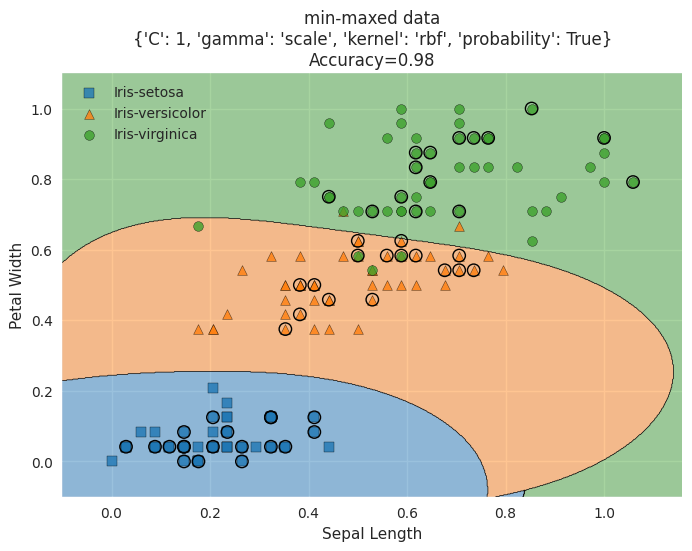

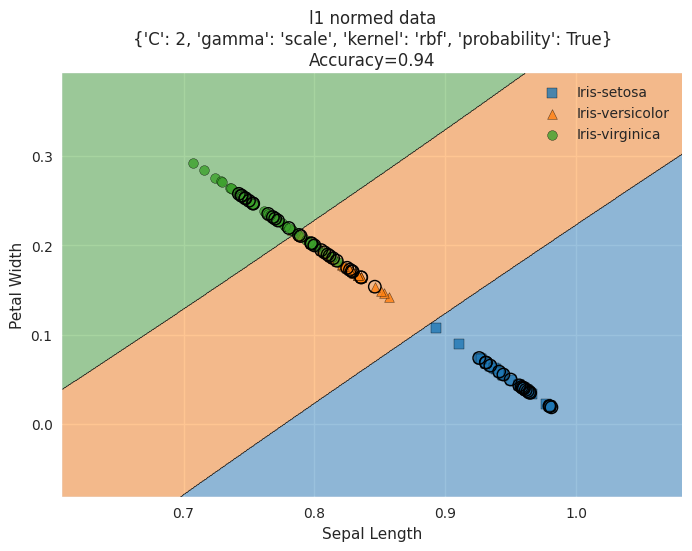

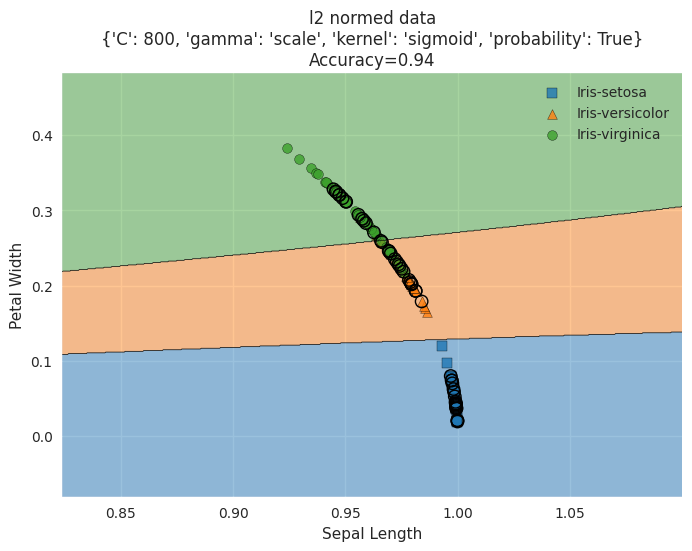

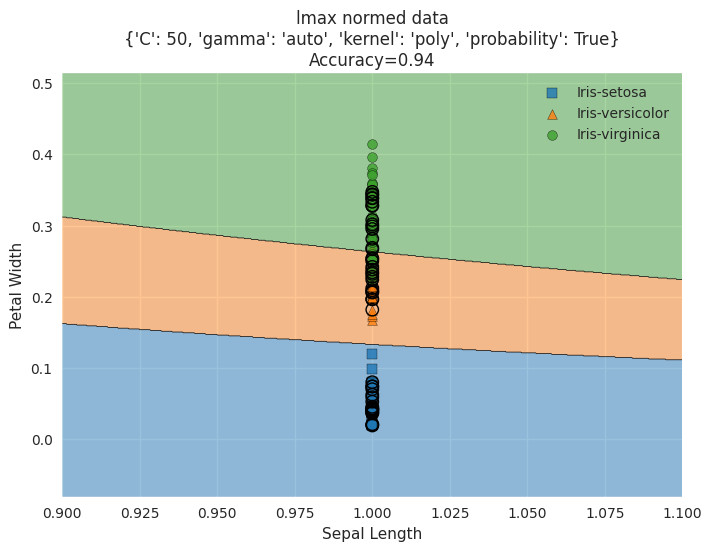

In [3]:
param_grid = {
    "C": [
        *range(1, 10, 1),
        *range(10, 100, 10),
        *range(100, 1000, 100),
    ],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "probability": [True, False],
}

# ParamGrid Length
print("ParamGrid length: {}".format(len(list(ParameterGrid(param_grid)))))

# For every preprocess modality
for name, preprocessor in [
    ("std-scaled", preprocessing.StandardScaler()),
    ("min-maxed", preprocessing.MinMaxScaler()),
    ("l1 normed", preprocessing.Normalizer(norm="l1")),
    ("l2 normed", preprocessing.Normalizer(norm="l2")),
    ("lmax normed", preprocessing.Normalizer(norm="max")),
]:
    gs = Pipeline(
        [
            (name, preprocessor),
            (
                "search",
                GridSearchCV(
                    svm.SVC(random_state=random_state),
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=5,
                    refit=True,
                ),
            ),
        ]
    )

    # Fit
    gs.fit(X_train.values, y_train)

    # Plot decision Regions
    if df_X.shape[1] == 2:
        # In this case the plot is a bit different: I manually composed the pipeline, inserting the preprocessed data as "X" and "X_highlight", and the estimator as "clf"
        plot_decision_regions(
            preprocessor.fit(X_train.values).transform(df_X.values),
            df_Y,
            clf=gs[1],
            legend=2,
            X_highlight=preprocessor.fit(X_train.values).transform(X_test.values),
            n_jobs=-1,
            zoom_factor=10,
        )
        plt.xlabel(df_X.columns[0])
        plt.ylabel(df_X.columns[1])
        plt.legend(encoder.classes_)
        plt.title(
            "{} data\n{}\nAccuracy={}".format(
                gs.steps[0][0],
                gs.steps[1][1].best_params_,
                gs.score(X_test.values, y_test),
            )
        )
        plt.show()
    else:
        print(
            "{} data\n{}\nAccuracy={}".format(
                gs.steps[0][0], gs.best_params_, gs.score(X_test.values, y_test)
            )
        )